# Final

## Clases de simulación y plot

### Clase de simulación

In [38]:
import numpy as np
from scipy.stats import norm, uniform, expon, t, gaussian_kde
import matplotlib.pyplot as plt

class ARMASimulation:
    def __init__(self, model_type='AR(1)', phi=[], theta=[], noise_dist='normal', sigma=1.0, seed=None):
        self.model_type = model_type
        self.phi = np.array(phi)
        self.theta = np.array(theta)
        self.noise_dist = noise_dist
        self.sigma = sigma
        self.seed = seed
        self.rng = np.random.default_rng(seed)
        self.series = None
        self.residuals = None

    def model_params(self):
        """Devuelve los parámetros del modelo en un diccionario."""
        return {
            'model_type': self.model_type,
            'phi': self.phi.tolist(),
            'theta': self.theta.tolist(),
            'sigma': self.sigma
        }
    def simulate(self, n=250, burn_in=50):
        """Simula una serie temporal con semilla."""
        total_length = n + burn_in
        
        # Generate errors with one extra element to avoid index out of bounds
        errors = self._generate_errors(total_length + 1)  # +1 to avoid out of bounds
        
        p = len(self.phi)
        q = len(self.theta)
        series = np.zeros(total_length)
        
        # Valores iniciales con semilla
        series[:max(p,q)] = self.rng.normal(0, self.sigma, max(p,q))
        
        for t in range(max(p,q), total_length):
            ar_part = np.dot(self.phi, series[t-p:t][::-1]) if p > 0 else 0
            ma_part = np.dot(self.theta, errors[t-q:t][::-1]) if q > 0 else 0
            series[t] = ar_part + errors[t] + ma_part
            
        self.series = series[burn_in:]
        return self.series
    
    def _generate_errors(self, n):
        """Genera errores con semilla."""
        if self.noise_dist == 'normal':
            return self.rng.normal(0, self.sigma, n)
        elif self.noise_dist == 'uniform':
            a = -np.sqrt(3)*self.sigma
            b = 2*np.sqrt(3)*self.sigma
            return uniform.rvs(loc=a, scale=b-a, size=n, random_state=self.rng)
        elif self.noise_dist == 'exponential':
            exp_errors = expon.rvs(scale=self.sigma, size=n, random_state=self.rng)
            return exp_errors - self.sigma
        elif self.noise_dist == 't-student':
            df = max(int(18*self.sigma**2/(9*self.sigma**2 - 1) + 1), 3)
            return t.rvs(df, scale=self.sigma/np.sqrt(3), size=n, random_state=self.rng)
        elif self.noise_dist == 'mixture':
            comp1 = norm.rvs(-0.25, np.sqrt(self.sigma**2 - 0.1875), size=int(n*0.75), random_state=self.rng)
            comp2 = norm.rvs(0.75, np.sqrt(self.sigma**2 - 0.1875), size=int(n*0.25), random_state=self.rng)
            return np.concatenate([comp1, comp2])[:n]
        else:
            raise ValueError("Distribución no soportada")

    def sieve_bootstrap(self, n_bootstrap=10, p_order=2, h=1):
        """Implementa Sieve Bootstrap con semilla."""
        if self.series is None:
            raise ValueError("Primero simule la serie")
        
        n = len(self.series)
        X = self.series - np.mean(self.series)
        
        # Estimación Yule-Walker
        r = np.zeros(p_order + 1)
        for k in range(p_order + 1):
            r[k] = np.mean(X[k:] * X[:n - k]) if k < n else 0
            
        R = toeplitz(r[:p_order])
        rho = r[1:p_order + 1]
        phi_hat = np.linalg.solve(R, rho)
        
        # Calcular residuos
        residuals = np.zeros(n - p_order)
        for t in range(p_order, n):
            residuals[t - p_order] = X[t] - np.dot(phi_hat, X[t - p_order:t][::-1])
        
        residuals_centered = residuals - np.mean(residuals)
        self.residuals = residuals_centered
        
        # Generar muestras bootstrap con semilla
        bootstrap_samples = []
        for _ in range(n_bootstrap):
            eps_star = self.rng.choice(residuals_centered, size=n + h, replace=True)
            X_star = np.zeros(n + h)
            X_star[:p_order] = X[:p_order]
            
            for t in range(p_order, n + h):
                X_star[t] = np.dot(phi_hat, X_star[t - p_order:t][::-1]) + eps_star[t]
                
            bootstrap_samples.append(X_star)
        
        return [sample[-h:] for sample in bootstrap_samples]

    
    def theoretical_density(self, x, last_values):
        """Calcula densidad teórica para y_{n+1}"""
        deterministic = self._get_deterministic_component(last_values)
        
        if self.noise_dist == 'normal':
            return norm.pdf(x, deterministic, self.sigma)
        elif self.noise_dist == 'uniform':
            a = deterministic - np.sqrt(3)*self.sigma
            b = deterministic + np.sqrt(3)*self.sigma
            return uniform.pdf(x, loc=a, scale=b-a)
        elif self.noise_dist == 'exponential':
            return expon.pdf(x + self.sigma - deterministic, scale=self.sigma)
        elif self.noise_dist == 't-student':
            # Corrección: Separar correctamente los argumentos de max()
            df_value = 18 * self.sigma**2 / (9 * self.sigma**2 - 1) + 1
            df = max(int(df_value), 3)  # Asegurar df >= 3
            return t.pdf((x - deterministic) * np.sqrt(3) / self.sigma, df) / (self.sigma / np.sqrt(3))
        elif self.noise_dist == 'mixture':
            comp1 = 0.75 * norm.pdf(x, deterministic - 0.25, np.sqrt(self.sigma**2 - 0.1875))
            comp2 = 0.25 * norm.pdf(x, deterministic + 0.75, np.sqrt(self.sigma**2 - 0.1875))
            return comp1 + comp2
    
    def _get_deterministic_component(self, last_values):
        """Calcula componente determinista del modelo"""
        p = len(self.phi)
        q = len(self.theta)
        ar_part = np.dot(self.phi, last_values[-p:][::-1]) if p > 0 else 0
        ma_part = np.dot(self.theta, self.residuals[-q:][::-1]) if q > 0 else 0
        return ar_part + ma_part

def toeplitz(c):
    """Crea matriz Toeplitz para Yule-Walker"""
    n = len(c)
    r = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            r[i,j] = c[np.abs(i-j)]
    return r


### Clase plotting

In [39]:
import seaborn as sns

class PlotManager:
    _STYLE = {
        'figsize': (14, 6),
        'grid_style': {'alpha': 0.3, 'linestyle': ':'},
        'default_colors': ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    }

    @classmethod
    def _base_plot(cls, title, xlabel, ylabel):
        plt.figure(figsize=cls._STYLE['figsize'])
        plt.title(title, fontsize=14, pad=15)
        plt.xlabel(xlabel, fontsize=12)
        plt.ylabel(ylabel, fontsize=12)
        plt.grid(**cls._STYLE['grid_style'])
        plt.gca().spines[['top', 'right']].set_visible(False)

    @classmethod
    def plot_series(cls, series, model_params, noise_type):
        cls._base_plot(
            f"Serie Temporal - {model_params['model_type']}",
            "Tiempo",
            "Valor"
        )
        plt.plot(series, color=cls._STYLE['default_colors'][0], linewidth=1.2, alpha=0.8)
        plt.tight_layout()
        plt.show()

    @classmethod
    def plot_density_comparison(cls, distributions, metric_values, colors=None):
        """Compara distribuciones con métricas ECRPS."""
        cls._base_plot("Comparación de Densidades Predictivas", "Valor", "Densidad")
        
        # Asignar colores
        default_colors = cls._STYLE['default_colors']
        colors = colors or {}
        
        for name, data in distributions.items():
            # Color: usar el proporcionado o uno por defecto
            color = colors.get(name)
            
            if color is None:
                raise ValueError(f"Color no definido para {name}. Asegúrate de que todos los nombres coincidan.")
            
            linestyle = '-' if name in ['Sieve Bootstrap', 'Distribución Teórica'] else '--'
            
            sns.kdeplot(
                data,
                color=color,
                label=name,
                linestyle=linestyle,
                linewidth=2,
                warn_singular=False
            )
        
        # Mostrar métricas ordenadas arriba a la derecha
        sorted_metrics = sorted(metric_values.items(), key=lambda x: x[1])
        metrics_text = "\n".join([f"{k}: {v:.4f}" for k, v in sorted_metrics])
        plt.text(
            0.95, 0.95,  # Posición superior derecha
            f'ECRPS:\n{metrics_text}',
            transform=plt.gca().transAxes,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray')
        )
        
        # Leyenda arriba a la izquierda
        plt.legend(loc='upper left', frameon=True)
        
        plt.tight_layout()
        plt.show()



## Clase de modelos

### Clase bootstrapping

In [40]:
from statsmodels.tsa.ar_model import AutoReg
from metrica import crps

class EnhancedBootstrappingModel:
    """Modelo mejorado con evaluación CRPS y comparación teórica"""
    
    def __init__(self, arma_simulator, random_state=42, verbose=False):
        self.n_lags = None
        self.random_state = random_state
        self.model = None
        self.mean_val = None
        self.std_val = None
        self.verbose = verbose
        self.arma_simulator = arma_simulator
        self.train = None
        self.test = None

    def prepare_data(self, series):
        """Prepara y divide los datos en train/test"""
        split_idx = int(len(series)*0.9)
        self.train = series[:split_idx]
        self.test = series[split_idx:]
        
        # Normalización
        self.mean_val = np.mean(self.train)
        self.std_val = np.std(self.train)
        return (self.train - self.mean_val)/self.std_val

    def denormalize(self, values):
        """Desnormaliza los valores"""
        return values * self.std_val + self.mean_val

    def fit_predict(self, data, n_boot=1000):
        """Genera predicciones bootstrap para múltiples pasos con manejo de errores"""
        normalized_train = self.prepare_data(data)
        test_predictions = []
        current_data = normalized_train.copy()
        
        for _ in range(len(self.test)):
            # Manejo de errores numéricos
            for attempt in range(3):  # Reintentar hasta 3 veces
                try:
                    self.model = AutoReg(current_data, lags=self.n_lags, old_names=False)
                    fitted_model = self.model.fit()
                    break
                except np.linalg.LinAlgError:
                    # Añadir pequeña perturbación para evitar singularidad
                    current_data += np.random.normal(0, 1e-6, len(current_data))
                    if self.verbose:
                        print("⚠️ Añadida perturbación para evitar matriz singular")
            
            # Generar predicción bootstrap
            residuals = fitted_model.resid
            rng = np.random.default_rng(seed=self.random_state)
            boot_preds = fitted_model.forecast(steps=1) + rng.choice(residuals, size=n_boot, replace=True)
            
            # Actualizar datos con la media de las predicciones
            current_data = np.append(current_data, np.mean(boot_preds))
            
            # Desnormalizar y guardar
            test_predictions.append(self.denormalize(boot_preds))
        
        return test_predictions

    def calculate_crps(self, distribution, true_value):
        """Calcula CRPS para una distribución vs valor real"""
        return crps(distribution, true_value)

    def grid_search(self, lags_range=range(1, 13), n_boot=500):
        """Búsqueda de mejores lags usando CRPS en train"""
        best_crps = float('inf')
        best_lag = None
        
        normalized_train = self.prepare_data(self.arma_simulator.series)
        
        for n_lags in lags_range:
            self.n_lags = n_lags
            crps_values = []
            try:
                # Walk-forward validation en train
                for t in range(n_lags+10, len(normalized_train)):
                    train_subset = normalized_train[:t]
                    test_value = normalized_train[t]
                    
                    # Ajustar modelo con manejo de errores
                    try:
                        model = AutoReg(train_subset, lags=n_lags, old_names=False)
                        fitted_model = model.fit()
                    except np.linalg.LinAlgError:
                        train_subset += np.random.normal(0, 1e-6, len(train_subset))
                        model = AutoReg(train_subset, lags=n_lags, old_names=False)
                        fitted_model = model.fit()
                    
                    # Generar predicción bootstrap
                    pred = fitted_model.forecast(steps=1)
                    residuals = fitted_model.resid
                    boot_preds = pred + np.random.choice(residuals, size=n_boot, replace=True)
                    
                    # Calcular CRPS
                    crps_val = self.calculate_crps(boot_preds, test_value)
                    crps_values.append(crps_val)
                
                avg_crps = np.nanmean(crps_values)  # Ignorar NaNs
                if avg_crps < best_crps:
                    best_crps = avg_crps
                    best_lag = n_lags
                    
            except Exception as e:
                if self.verbose:
                    print(f"❌ Error con lag={n_lags}: {str(e)}")
                continue

        self.n_lags = best_lag
        if self.verbose:
            print(f"✅ Mejor n_lags: {best_lag} (CRPS promedio: {best_crps:.4f})")
        return best_lag, best_crps

    def evaluate_test(self, n_boot=1000):
        """Evalúa el modelo en el conjunto de test usando ECRPS"""
        bootstrap_preds = self.fit_predict(self.arma_simulator.series, n_boot)
        theoretical_preds = []
        
        for i in range(len(self.test)):
            deterministic = self.arma_simulator._get_deterministic_component(self.train[-len(self.arma_simulator.phi):])
            if self.arma_simulator.noise_dist == 't-student':
                df_value = 18 * self.arma_simulator.sigma**2 / (9 * self.arma_simulator.sigma**2 - 1) + 1
                df = max(int(df_value), 3)
                samples = deterministic + t.rvs(df, scale=self.arma_simulator.sigma/np.sqrt(3), size=1000)
                theoretical_preds.append(samples)
            else:
                theoretical_preds.append(np.full(1000, np.nan))
        
        return {
            'bootstrap_crps': np.mean([self.calculate_crps(pred, true) for pred, true in zip(bootstrap_preds, self.test)]),
            'theoretical_crps': np.mean([self.calculate_crps(pred, true) for pred, true in zip(theoretical_preds, self.test)])
        }


### CPNewModel

In [41]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import Ridge
from bayes_opt import BayesianOptimization
from metrica import crps

class CPnewModel:
    """Modelo avanzado para series temporales con optimización bayesiana usando CRPS."""
    
    def __init__(self, n_lags=5, rho=0.95, max_points=10000, alpha=0.1, poly_degree=2, 
                 seasonal_periods=[12], random_state=42, verbose=False):
        self.n_lags = n_lags
        self.rho = rho
        self.max_points = max_points
        self.alpha = alpha
        self.poly_degree = poly_degree
        self.seasonal_periods = seasonal_periods
        self.mean_val = None
        self.std_val = None
        self.trends = []
        self.seasonalities = []
        self.random_state = random_state
        self.verbose = verbose
        np.random.seed(self.random_state)

    def optimize_hyperparameters(self, df, real_noise):
        """Optimiza hiperparámetros usando Bayesian Optimization con CRPS."""
        def objective(n_lags, rho, poly_degree):
                try:
                    n_lags_int = max(1, int(round(n_lags)))
                    rho_bounded = min(0.999, max(0.5, float(rho)))
                    poly_degree_int = max(1, int(round(poly_degree)))
                    
                    if len(df) <= n_lags_int * 2:
                        return -1e10  # Valor finito en lugar de -inf
                    
                    self.n_lags = n_lags_int
                    self.rho = rho_bounded
                    self.poly_degree = poly_degree_int
                    
                    predictions = self.fit_predict(df.copy())
                    
                    if np.any(np.isnan(predictions)) or np.any(np.isinf(predictions)):
                        return -1e10  # Valor finito
                    
                    # Calcular CRPS
                    try:
                        crps_value = crps(predictions, real_noise)
                    except:
                        return -1e10
                    
                    # Penalización por parámetros extremos
                    penalty = 0
                    if n_lags_int > 8:
                        penalty += 0.1 * (n_lags_int - 8)
                    if rho_bounded > 0.98:
                        penalty += 0.1 * (rho_bounded - 0.98) / 0.019
                    
                    return -(crps_value + penalty)
                        
                except Exception as e:
                    if self.verbose:
                        print(f"Error en iteración: {str(e)}")
                    return -1e10  # Valor finito

        optimizer = BayesianOptimization(
            f=objective,
            pbounds={
                'n_lags': (1, 8),
                'rho': (0.7, 0.99),
                'poly_degree': (1, 3)
            },
            random_state=self.random_state,
            verbose=0
        )
        
        try:
            optimizer.maximize(init_points=10, n_iter=15)
        except Exception as e:
            if self.verbose:
                print(f"Error durante optimización: {str(e)}")
            return self.n_lags, self.rho, self.poly_degree, -1e10

        
        if optimizer.max:
            best_params = optimizer.max['params']
            optimizer.set_bounds({
                'n_lags': (max(1, best_params['n_lags']-1), min(8, best_params['n_lags']+1)),
                'rho': (max(0.7, best_params['rho']-0.05), min(0.99, best_params['rho']+0.05)),
                'poly_degree': (max(1, best_params['poly_degree']-1), min(3, best_params['poly_degree']+1))
            })
            optimizer.maximize(init_points=5, n_iter=10)

        if optimizer.max and optimizer.max['target'] > -float('inf'):
            final_params = optimizer.max['params']
            best_crps = -optimizer.max['target'] - final_params.get('penalty', 0)
            
            self.n_lags = max(1, int(round(final_params['n_lags'])))
            self.rho = min(0.999, max(0.5, final_params['rho']))
            self.poly_degree = max(1, int(round(final_params['poly_degree'])))

            if self.verbose:
                print("✅ Optimización exitosa:")
                print(f"  • Lags: {self.n_lags}")
                print(f"  • Rho: {self.rho:.3f}")
                print(f"  • Grado polinomial: {self.poly_degree}")
                print(f"  • CRPS: {best_crps:.4f}")
        else:
            self.n_lags = 3
            self.rho = 0.85
            self.poly_degree = 2
            if self.verbose:
                print("⚠️ Optimización fallida. Usando valores por defecto.")
        
        return self.n_lags, self.rho, self.poly_degree, best_crps

    def decompose_series(self, df):
        """Elimina tendencia y estacionalidades usando numpy arrays"""
        values = df['valor'].values if isinstance(df, pd.DataFrame) else df
        residual = values.copy().astype(np.float64)

        self.trends = []
        self.seasonalities = []

        for period in self.seasonal_periods:
            if len(residual) >= 2 * period:
                result = seasonal_decompose(residual, period=period, model='additive', extrapolate_trend='freq')
                self.trends.append(result.trend.astype(np.float64))
                self.seasonalities.append(result.seasonal.astype(np.float64))
                residual -= np.nan_to_num(result.trend) + np.nan_to_num(result.seasonal)

        return np.nan_to_num(residual)

    def recombine_components(self, predictions):
        """Agrega componentes estructurales usando numpy"""
        trend_sum = sum(trend[-1] for trend in self.trends if trend is not None and len(trend) > 0)
        seasonal_sum = sum(season[-1] for season in self.seasonalities if season is not None and len(season) > 0)
        return predictions + trend_sum + seasonal_sum

    def _create_lag_matrix(self, values, n_lags, degree=2):
        """Crea matriz de rezagos con términos polinomiales (versión sin Numba)"""
        n = len(values) - n_lags
        X = np.ones((n, 1), dtype=np.float64)
        for lag in range(n_lags):
            lagged = values[lag:lag + n].reshape(-1, 1).astype(np.float64)
            X = np.hstack((X, lagged))
            if degree > 1:
                for d in range(2, degree + 1):
                    X = np.hstack((X, np.power(lagged, d)))
        return X

    def prepare_data(self, df):
        """Preprocesamiento robusto con numpy"""
        detrended_values = self.decompose_series(df)
        detrended_values = np.nan_to_num(detrended_values)
        self.mean_val = np.mean(detrended_values)
        self.std_val = np.std(detrended_values)
        return (detrended_values - self.mean_val) / (self.std_val + 1e-8)

    def adaptive_regularization(self, X):
        """Regularización adaptativa basada en SVD"""
        _, s, _ = np.linalg.svd(X.astype(np.float64))
        condition_number = s[0] / (s[-1] + 1e-10)
        return min(1.0, 1 / (condition_number + 1e-5))

    def calculate_C_values(self, X, y):
        """Calcula los valores C con Ridge"""
        alpha = self.adaptive_regularization(X)
        model = Ridge(alpha=alpha, fit_intercept=False)
        model.fit(X.astype(np.float64), y.astype(np.float64))
        y_pred = model.predict(X)
        residuals = y - y_pred
        XtX_inv = np.linalg.pinv(X.T @ X + alpha * np.eye(X.shape[1]))
        return y_pred + (X @ XtX_inv @ X.T @ residuals)

    def apply_weights(self, C):
        """Aplica pesos exponenciales con numpy puro"""
        weights = self.rho ** np.arange(len(C)-1, -1, -1, dtype=np.float64)
        weights /= np.sum(weights)
        scale_factor = min(self.max_points / np.sum(weights), 100)
        repeats = np.maximum(np.round(weights * scale_factor), 1).astype(int)
        return np.repeat(C.astype(np.float64), repeats)

    def fit_predict(self, df):
        """Genera predicciones con manejo robusto de tipos de datos"""
        try:
            # Convertir a numpy array si es necesario
            if isinstance(df, pd.DataFrame):
                df = df['valor'].values.astype(np.float64)
            
            normalized = self.prepare_data(df)
            
            # Validar longitud suficiente
            if len(normalized) < self.n_lags + self.poly_degree:
                return np.zeros(self.max_points, dtype=np.float64)
            
            X = self._create_lag_matrix(normalized, self.n_lags, self.poly_degree)
            y = normalized[self.n_lags:].astype(np.float64)
            
            # Calcular valores C
            C = self.calculate_C_values(X, y)
            
            # Aplicar pesos y desnormalizar
            weighted = self.apply_weights(C)
            denormalized = (weighted * self.std_val) + self.mean_val
            
            return self.recombine_components(denormalized)
            
        except Exception as e:
            print(f"Error en fit_predict: {str(e)}")
            return np.zeros(self.max_points, dtype=np.float64)


### CPnewModelQn

In [42]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import Ridge
from bayes_opt import BayesianOptimization
from metrica import crps, ecrps
from sklearn.utils import check_random_state

class CPnewModelQn:
    def __init__(self, n_lags=5, rho=0.95, max_points=1000, alpha=0.1, poly_degree=2, 
                 seasonal_periods=None, random_state=42, verbose=False):
        self.n_lags = n_lags
        self.rho = rho
        self.max_points = max_points
        self.alpha = alpha
        self.poly_degree = poly_degree
        self.seasonal_periods = seasonal_periods if seasonal_periods is not None else []
        self.mean_val = None
        self.std_val = None
        self.trend_models = []
        self.seasonal_models = []
        self.random_state = random_state
        self.rng = check_random_state(random_state)
        self.verbose = verbose
        np.random.seed(random_state)

    def optimize_hyperparameters(self, df, real_noise):
        """Optimiza hiperparámetros usando Bayesian Optimization con CRPS."""
        def objective(n_lags, rho, poly_degree):
            try:
                n_lags = int(round(n_lags))
                rho = np.clip(rho, 0.5, 0.99)
                poly_degree = int(round(poly_degree))
                
                # Validar longitud de datos
                max_seasonal = max(self.seasonal_periods) if self.seasonal_periods else 0
                if len(df) < 2 * (n_lags + max_seasonal):
                    return -1e12
                
                self.n_lags = n_lags
                self.rho = rho
                self.poly_degree = poly_degree
                
                # Generar predicciones
                distribution = self.fit_predict(df)
                if not distribution:
                    return -1e12
                
                # Muestrear de la distribución
                values = np.array([d['value'] for d in distribution])
                probs = np.array([d['probability'] for d in distribution])
                probs_sum = probs.sum()
                if probs_sum <= 0:
                    return -1e12
                probs_normalized = probs / probs_sum
                samples = self.rng.choice(values, size=1000, p=probs_normalized)
                
                # Asegurar que samples y real_noise son 1D
                samples = np.asarray(samples).reshape(-1)
                
                # Verificamos que real_noise sea un array
                if not isinstance(real_noise, np.ndarray):
                    real_noise_flat = np.asarray(real_noise)
                else:
                    real_noise_flat = real_noise
                
                # Forzamos 1D
                real_noise_flat = real_noise_flat.reshape(-1)
                
                # Validar dimensiones y longitud
                if len(real_noise_flat) == 0:
                    return -1e12
                
                # Imprimir formas para depuración si está en modo verbose
                
                # Calcular CRPS
                try:
                    score = -crps(samples, real_noise_flat)
                    return score
                except Exception as inner_e:
                    if self.verbose:
                        print(f"Error en cálculo de CRPS: {inner_e}")
                    return -1e12
            
            except Exception as e:
                if self.verbose:
                    print(f"Error en iteración: {str(e)}")
                return -1e12

        optimizer = BayesianOptimization(
            f=objective,
            pbounds={
                'n_lags': (3, 5),
                'rho': (0.6, 0.97),
                'poly_degree': (1, 2)
            },
            random_state=self.random_state,
            allow_duplicate_points=True,
            verbose=0
        )
        
        try:
            optimizer.maximize(init_points=5, n_iter=10)
            if optimizer.max:
                best = optimizer.max['params']
                self.n_lags = int(round(best['n_lags']))
                self.rho = best['rho']
                self.poly_degree = int(round(best['poly_degree']))
                best_crps = -optimizer.max['target']
                if self.verbose:
                    print(f"\n✅ Optimización exitosa:\n  • Lags: {self.n_lags}\n  • Rho: {self.rho:.3f}\n  • Grado polinomial: {self.poly_degree}\n  • CRPS: {best_crps:.4f}")
                return self.n_lags, self.rho, self.poly_degree, best_crps
        except Exception as e:
            print(f"Error en optimización: {str(e)}")
            return self.n_lags, self.rho, self.poly_degree, -1e12

    def _decompose(self, series):
        """Elimina tendencia y estacionalidades."""
        residual = series.copy()
        self.trend_models = []
        self.seasonal_models = []
        
        for period in self.seasonal_periods:
            if len(residual) < 2 * period:
                continue
                
            try:
                decomp = seasonal_decompose(residual, period=period, model='additive', extrapolate_trend='freq')
                trend = decomp.trend
                seasonal = decomp.seasonal
                
                # Modelado de tendencia
                X = np.arange(len(trend)).reshape(-1, 1)
                valid = ~np.isnan(trend)
                if np.sum(valid) > 1:
                    model = Ridge(alpha=self.alpha).fit(X[valid], trend[valid])
                    trend_pred = model.predict(X)
                else:
                    trend_pred = np.zeros_like(trend)
                
                # Modelado estacional
                seasonal_model = np.zeros(period)
                seasonal_indices = np.tile(np.arange(period), len(residual) // period + 1)[:len(residual)]
                for i in range(period):
                    mask = seasonal_indices == i
                    if np.any(mask):
                        seasonal_model[i] = np.nanmean(seasonal[mask])
                seasonal_series = seasonal_model[seasonal_indices]
                
                residual = residual - trend_pred - seasonal_series
                self.trend_models.append(model if np.sum(valid) > 1 else None)
                self.seasonal_models.append(seasonal_model)
            except Exception as e:
                if self.verbose:
                    print(f"Error en descomposición: {e}")
                continue
        
        residual = np.nan_to_num(residual, nan=np.nanmedian(residual))
        return residual

    def _calculate_C(self, X, y, weights):
        """Calcula los valores C con Ridge."""
        model = Ridge(alpha=self.alpha, fit_intercept=False)
        model.fit(X, y, sample_weight=weights)
        return model.predict(X)

    def _Qn_distribution(self, C, original_length):
        """Genera la distribución Qn."""
        sorted_C = np.sort(C)
        n = len(sorted_C)
        distribution = []
        
        # Componentes estructurales para la predicción
        next_trend = 0
        for model in self.trend_models:
            if model is not None:
                try:
                    next_trend += model.predict([[original_length + 1]])[0]
                except Exception as e:
                    if self.verbose:
                        print(f"Error en predicción de tendencia: {e}")
        
        next_seasonal = 0
        for model in self.seasonal_models:
            if len(model) > 0:
                try:
                    next_seasonal += model[(original_length + 1) % len(model)]
                except Exception as e:
                    if self.verbose:
                        print(f"Error en predicción estacional: {e}")
        
        # Generar intervalos
        for i in range(n):
            current_val = sorted_C[i]
            denorm = current_val * self.std_val + self.mean_val
            full_value = denorm + next_trend + next_seasonal
            
            lower_prob = i / (n + 1)
            upper_prob = (i + 1) / (n + 1)
            
            if i > 0 and np.isclose(current_val, sorted_C[i-1]):
                distribution[-1]['probability'] = upper_prob - distribution[-1]['lower']
                distribution[-1]['upper'] = upper_prob
            else:
                distribution.append({
                    'value': full_value,
                    'lower': lower_prob,
                    'upper': upper_prob,
                    'probability': upper_prob - lower_prob
                })
        
        return distribution

    def fit_predict(self, df):
        """Genera la distribución predictiva."""
        try:
            # Manejar diferentes tipos de entrada
            if isinstance(df, pd.DataFrame):
                if 'valor' in df.columns:
                    values = df['valor'].values
                else:
                    # Asumimos que es una serie de un solo valor
                    values = df.iloc[:, 0].values
            else:
                values = np.asarray(df)
            
            if len(values) < self.n_lags * 2:
                if self.verbose:
                    print("Error: Datos insuficientes para el modelo.")
                return []
            
            residual = self._decompose(values)
            self.mean_val = np.nanmean(residual)
            self.std_val = np.nanstd(residual) + 1e-8
            normalized = (residual - self.mean_val) / self.std_val
            
            if len(normalized) < self.n_lags:
                if self.verbose:
                    print("Error: Datos insuficientes tras normalización.")
                return []
            
            # Crear características polinómicas de forma más cuidadosa
            X = []
            y = []
            
            for i in range(self.n_lags, len(normalized)):
                ar_features = normalized[i - self.n_lags:i]
                
                # Crear features polinómicas uno por uno para evitar problemas de dimensiones
                all_features = []
                for d in range(self.poly_degree):
                    degree_features = ar_features ** (d+1)
                    all_features.append(degree_features)
                
                # Concatenar horizontalmente (no verticalmente)
                X.append(np.concatenate(all_features))
                y.append(normalized[i])
            
            # Convertir a arrays numpy
            if len(X) == 0 or len(y) == 0:
                if self.verbose:
                    print("Error: No se pudieron crear suficientes características.")
                return []
                
            X = np.array(X)
            y = np.array(y)
            
            # Aplicar pesos exponenciales
            weights = self.rho ** np.arange(len(y))[::-1]
            weights /= weights.sum() + 1e-8
            
            C = self._calculate_C(X, y, weights)
            
            return self._Qn_distribution(C, original_length=len(values))
        
        except Exception as e:
            if self.verbose:
                print(f"Error crítico en fit_predict: {str(e)}")
            return []


### DeepAR

In [43]:
 
import numpy as np
import pandas as pd
from metrica import ecrps
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization


import torch
import torch.nn as nn
import torch.optim as optim

class DeepARModel:
    """DeepAR modificado para optimización con CRPS"""
    
    def __init__(self, hidden_size=20, n_lags=5, num_layers=1, dropout=0.1,
                 lr=0.01, batch_size=32, epochs=100, num_samples=1000, random_state=42, verbose=False):
        self.hidden_size = hidden_size
        self.n_lags = n_lags
        self.num_layers = num_layers
        self.dropout = dropout
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.num_samples = num_samples
        self.model = None
        self.scaler_mean = None
        self.scaler_std = None
        self.random_state = random_state
        self.verbose = verbose
        self.best_params = None

        np.random.seed(random_state)
        torch.manual_seed(random_state)

    class _DeepARNN(nn.Module):
        """Arquitectura neuronal de DeepAR"""
        def __init__(self, input_size, hidden_size, num_layers, dropout):
            super().__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                               batch_first=True, dropout=dropout)
            self.fc_mu = nn.Linear(hidden_size, 1)
            self.fc_sigma = nn.Linear(hidden_size, 1)

        def forward(self, x):
            lstm_out, _ = self.lstm(x)
            last_out = lstm_out[:, -1, :]
            mu = self.fc_mu(last_out)
            sigma = torch.exp(self.fc_sigma(last_out))
            return mu, sigma

    def _create_sequences(self, series):
        """Crea secuencias para entrenamiento"""
        X, y = [], []
        for i in range(len(series) - self.n_lags):
            X.append(series[i:i + self.n_lags])
            y.append(series[i + self.n_lags])
        return np.array(X), np.array(y)

    def _train_model(self, X_train, y_train):

        X_tensor = torch.FloatTensor(X_train.reshape(-1, self.n_lags, 1))
        y_tensor = torch.FloatTensor(y_train.reshape(-1, 1))

        model = self._DeepARNN(1, self.hidden_size, self.num_layers, self.dropout)
        criterion = nn.GaussianNLLLoss()
        optimizer = optim.Adam(model.parameters(), lr=self.lr)

        model.train()
        for epoch in range(self.epochs):
            permutation = torch.randperm(X_tensor.size(0))
            for i in range(0, X_tensor.size(0), self.batch_size):
                indices = permutation[i:i + self.batch_size]
                batch_x, batch_y = X_tensor[indices], y_tensor[indices]

                mu, sigma = model(batch_x)
                loss = criterion(mu, batch_y, sigma)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if (epoch + 1) % 20 == 0 and self.verbose:
                print(f'Epoch [{epoch + 1}/{self.epochs}], Loss: {loss.item():.4f}')

        return model

    def calculate_crps(self, predictions, observations):
        """Calcula el CRPS promedio entre predicciones y observaciones."""
        return crps(predictions, observations)
    
    def optimize_hyperparameters(self, df, real_noise):
        """Optimización bayesiana usando CRPS."""

        best_crps = np.inf
        best_params = None

        def objective(n_lags, hidden_size, num_layers, dropout, lr):
            nonlocal best_crps, best_params
            self.n_lags = max(1, int(n_lags))
            self.hidden_size = max(5, int(hidden_size))
            self.num_layers = max(1, int(num_layers))
            self.dropout = min(0.5, max(0.0, dropout))
            self.lr = max(0.0001, lr)

            try:
                predictions = self.fit_predict(df.copy())
                
                # Calcular CRPS
                current_crps = self.calculate_crps(predictions, real_noise)
                
                # Actualizar mejores valores si corresponde
                if current_crps < best_crps or np.isnan(best_crps):
                    best_crps = current_crps
                    best_params = {
                        'n_lags': self.n_lags,
                        'hidden_size': self.hidden_size,
                        'num_layers': self.num_layers,
                        'dropout': self.dropout,
                        'lr': self.lr
                    }
                
                return -current_crps  # Minimizar el CRPS
                
            except Exception as e:
                if self.verbose:
                    print(f"Error en optimización: {str(e)}")
                return -float('inf')

        optimizer = BayesianOptimization(
            f=objective,
            pbounds={
                'n_lags': (1, 10),
                'hidden_size': (5, 30),
                'num_layers': (1, 3),
                'dropout': (0.0, 0.5),
                'lr': (0.001, 0.1)
            },
            random_state=self.random_state,
            verbose=0
        )

        optimizer.maximize(init_points=3, n_iter=7)

        # Procesar resultados
        if optimizer.max:
            best_crps = -optimizer.max['target']
            best_params = {
                'n_lags': max(1, int(optimizer.max['params']['n_lags'])),
                'hidden_size': max(5, int(optimizer.max['params']['hidden_size'])),
                'num_layers': max(1, int(optimizer.max['params']['num_layers'])),
                'dropout': min(0.5, max(0.0, optimizer.max['params']['dropout'])),
                'lr': max(0.0001, optimizer.max['params']['lr'])
            }
            
            if self.verbose:
                print("✅ Optimización DeepAR Exitosa:")
                print(f"  • CRPS: {best_crps:.4f}")
                print(f"  • Lags: {best_params['n_lags']}")
                print(f"  • Hidden Size: {best_params['hidden_size']}")
                print(f"  • Capas LSTM: {best_params['num_layers']}")
                print(f"  • Dropout: {best_params['dropout']:.3f}")
                print(f"  • Learning Rate: {best_params['lr']:.4f}")

        self.best_params = best_params
        
        return best_params, best_crps

    def fit_predict(self, df):
        """Genera predicciones con manejo robusto de errores"""
        try:
            # Preparación de datos
            series = df['valor'].values if isinstance(df, pd.DataFrame) else df
            self.scaler_mean = np.nanmean(series)
            self.scaler_std = np.nanstd(series)
            normalized_series = (series - self.scaler_mean) / (self.scaler_std + 1e-8)

            # Crear secuencias
            X_train, y_train = self._create_sequences(normalized_series)
            
            if self.model is not None:
                # Entrenar modelo con PyTorch
                self.model = self._train_model(X_train, y_train)

                # Generar predicciones
                last_sequence = normalized_series[-self.n_lags:].reshape(1, self.n_lags, 1)
                last_sequence_tensor = torch.FloatTensor(last_sequence)
                
                self.model.eval()
                with torch.no_grad():
                    mu, sigma = self.model(last_sequence_tensor)
                    mu = mu.item()
                    sigma = sigma.item()
                    
                # Muestrear distribución normal
                samples = np.random.normal(mu, sigma, self.num_samples)
            else:
                # Fallback a aproximación gaussiana simple
                if len(y_train) > 0:
                    mu = np.nanmean(y_train)
                    sigma = np.nanstd(y_train)
                else:
                    mu = 0
                    sigma = 1
                samples = np.random.normal(mu, sigma, self.num_samples)

            # Desnormalizar y asegurar tipos de datos
            predictions = (samples * self.scaler_std + self.scaler_mean).astype(np.float64)
            predictions = np.nan_to_num(predictions, nan=0.0, posinf=0.0, neginf=0.0)
            
            return predictions
            
        except Exception as e:
            if self.verbose:
                print(f"Error crítico en fit_predict: {str(e)}")
            return np.zeros(self.num_samples, dtype=np.float64)

    def evaluate_model(self, predictions, real_values):
        """Evaluación completa del modelo"""
        metrics = {
            'CRPS': self.calculate_crps(predictions, real_values)
        }
        return metrics


## Clases de orden

### Pipeline

In [52]:
import numpy as np
import pandas as pd
from scipy.stats import t
from metrica import crps, ecrps

class Pipeline:
    def __init__(self, model_type='ARMA(1,1)', phi=[0.7], theta=[0.3], sigma=1.2,
                 noise_dist='t-student', n_samples=1000, seed=42, verbose=True):
        self.model_type = model_type
        self.phi = phi
        self.theta = theta
        self.sigma = sigma
        self.noise_dist = noise_dist
        self.n_samples = n_samples
        self.seed = seed
        self.verbose = verbose
        self.simulator = None
        self.series = None
        self.train_data = None
        self.test_data = None
        self.sieve_samples_flat = None
        self.theoretical_samples = None
        self.bootstrap_model = None
        self.cp_model = None
        self.cp_model_qn = None
        self.deepar_model = None
        self.resultados = {}  # Inicializar el atributo resultados

    def run_simulation(self):
        np.random.seed(self.seed)

        # 1. Simulación de datos
        self.simulator = ARMASimulation(
            model_type=self.model_type,
            phi=self.phi,
            theta=self.theta,
            sigma=self.sigma,
            noise_dist=self.noise_dist,
            seed=self.seed
        )
        self.series = self.simulator.simulate(n=self.n_samples)

        # 2. División train/test
        split_idx = int(len(self.series) * 0.9)
        self.train_data, self.test_data = self.series[:split_idx], self.series[split_idx:]

        # 3. Generar distribuciones de referencia
        # Sieve Bootstrap
        sieve_samples = self.simulator.sieve_bootstrap(n_bootstrap=1000, p_order=2, h=1)
        self.sieve_samples_flat = np.concatenate(sieve_samples).flatten()

        # Distribución teórica
        deterministic = self.simulator._get_deterministic_component(self.train_data[-len(self.simulator.phi):])
        df = max(int(18 * self.simulator.sigma**2 / (9 * self.simulator.sigma**2 - 1) + 1), 3)
        rng = np.random.default_rng(self.seed)
        self.theoretical_samples = deterministic + t.rvs(df, scale=self.simulator.sigma / np.sqrt(3), size=1000, random_state=rng)
        self.theoretical_samples = self.theoretical_samples.flatten()

    def train_models(self):
        # 4. Entrenar modelos
        # Modelo 1: EnhancedBootstrappingModel
        self.bootstrap_model = EnhancedBootstrappingModel(self.simulator, random_state=self.seed)
        self.bootstrap_model.grid_search()
        bootstrap_preds = self.bootstrap_model.fit_predict(self.train_data, n_boot=1000)
        bootstrap_preds_flat = np.concatenate(bootstrap_preds).flatten()

        # Modelo 2: CPnewModel
        self.cp_model = CPnewModel(random_state=self.seed, verbose=self.verbose)
        self.cp_model.optimize_hyperparameters(self.train_data, self.sieve_samples_flat)
        cp_preds = self.cp_model.fit_predict(self.train_data).flatten()

        # Modelo 3: CPnewModelQn
        self.cp_model_qn = CPnewModelQn(random_state=self.seed, verbose=self.verbose)
        self.cp_model_qn.optimize_hyperparameters(self.train_data, self.sieve_samples_flat)
        cp_qn_distribution = self.cp_model_qn.fit_predict(self.train_data)

        # Convertir distribución Qn a array 1D
        if cp_qn_distribution:
            values = np.array([d['value'] for d in cp_qn_distribution])
            probs = np.array([d['probability'] for d in cp_qn_distribution])
            probs_normalized = probs / probs.sum()
            cp_qn_preds = np.random.choice(values, size=1000, p=probs_normalized).flatten()
        else:
            cp_qn_preds = np.zeros(1000)

        # Modelo 4: DeepARModel
        self.deepar_model = DeepARModel(random_state=self.seed, verbose=self.verbose)
        deepar_params, deepar_crps = self.deepar_model.optimize_hyperparameters(self.train_data, self.sieve_samples_flat)
        deepar_preds = self.deepar_model.fit_predict(self.train_data).flatten()

        # Almacenar las predicciones en el atributo resultados
        self.resultados = {
            'bootstrap_preds_flat': bootstrap_preds_flat,
            'cp_preds': cp_preds,
            'cp_qn_preds': cp_qn_preds,
            'deepar_preds': deepar_preds
        }

    def calculate_metrics(self, bootstrap_preds_flat, cp_preds, cp_qn_preds, deepar_preds):
        # 5. Calcular métricas para todos los modelos
        metrics = {
            'ecrps_bootstrap_vs_sieve': ecrps(bootstrap_preds_flat, self.sieve_samples_flat),
            'ecrps_bootstrap_vs_theoretical': ecrps(bootstrap_preds_flat, self.theoretical_samples),
            'ecrps_cp_vs_sieve': ecrps(cp_preds, self.sieve_samples_flat),
            'ecrps_cp_vs_theoretical': ecrps(cp_preds, self.theoretical_samples),
            'ecrps_cp_qn_vs_sieve': ecrps(cp_qn_preds, self.sieve_samples_flat),
            'ecrps_cp_qn_vs_theoretical': ecrps(cp_qn_preds, self.theoretical_samples),
            'ecrps_deepar_vs_sieve': ecrps(deepar_preds, self.sieve_samples_flat),
            'ecrps_deepar_vs_theoretical': ecrps(deepar_preds, self.theoretical_samples)
        }
        return metrics

    def create_dataframes(self, metrics):
        # DataFrame de hiperparámetros
        df_hiperparametros = pd.DataFrame({
            'Modelo': ['Enhanced Bootstrapping', 'CPnewModel', 'CPnewModelQn', 'DeepAR'],
            'n_lags': [
                self.bootstrap_model.n_lags,
                self.cp_model.n_lags,
                self.cp_model_qn.n_lags,
                self.deepar_model.best_params['n_lags']
            ],
            'rho': [None, self.cp_model.rho, self.cp_model_qn.rho, None],
            'poly_degree': [None, self.cp_model.poly_degree, self.cp_model_qn.poly_degree, None],
            'hidden_size': [None, None, None, self.deepar_model.best_params['hidden_size']],
            'num_layers': [None, None, None, self.deepar_model.best_params['num_layers']],
            'dropout': [None, None, None, self.deepar_model.best_params['dropout']],
            'lr': [None, None, None, self.deepar_model.best_params['lr']]
        })

        # DataFrames de ECRPS separados
        df_ecrps_sieve = pd.DataFrame({
            'Comparación': [
                'Enhanced vs Sieve',
                'CPnewModel vs Sieve',
                'CPnewModelQn vs Sieve',
                'DeepAR vs Sieve'
            ],
            'ECRPS': [
                metrics['ecrps_bootstrap_vs_sieve'],
                metrics['ecrps_cp_vs_sieve'],
                metrics['ecrps_cp_qn_vs_sieve'],
                metrics['ecrps_deepar_vs_sieve']
            ]
        })

        df_ecrps_theoretical = pd.DataFrame({
            'Comparación': [
                'Enhanced vs Teórica',
                'CPnewModel vs Teórica',
                'CPnewModelQn vs Teórica',
                'DeepAR vs Teórica'
            ],
            'ECRPS': [
                metrics['ecrps_bootstrap_vs_theoretical'],
                metrics['ecrps_cp_vs_theoretical'],
                metrics['ecrps_cp_qn_vs_theoretical'],
                metrics['ecrps_deepar_vs_theoretical']
            ]
        })

        return df_hiperparametros, df_ecrps_sieve, df_ecrps_theoretical

    def visualize_results(self, df_hiperparametros, df_ecrps_sieve, df_ecrps_theoretical, 
                         bootstrap_preds_flat, cp_preds, cp_qn_preds, deepar_preds, metrics):
        if self.verbose:
            print("\n🔍 Mejores Hiperparámetros por Modelo:")
            display(df_hiperparametros)

            print("\n📊 ECRPS vs Sieve Bootstrap:")
            display(df_ecrps_sieve)

            print("\n📊 ECRPS vs Distribución Teórica:")
            display(df_ecrps_theoretical)

            PlotManager.plot_density_comparison(
                distributions={
                    'Sieve Bootstrap': self.sieve_samples_flat,
                    'Enhanced Bootstrapping': bootstrap_preds_flat,
                    'CPnewModel': cp_preds,
                    'CPnewModelQn': cp_qn_preds,
                    'DeepAR': deepar_preds,
                    'Distribución Teórica': self.theoretical_samples
                },
                metric_values={
                    'Enhanced vs Sieve': metrics['ecrps_bootstrap_vs_sieve'],
                    'CPnewModel vs Sieve': metrics['ecrps_cp_vs_sieve'],
                    'CPnewModelQn vs Sieve': metrics['ecrps_cp_qn_vs_sieve'],
                    'DeepAR vs Sieve': metrics['ecrps_deepar_vs_sieve'],
                    'Enhanced vs Teórica': metrics['ecrps_bootstrap_vs_theoretical'],
                    'CPnewModel vs Teórica': metrics['ecrps_cp_vs_theoretical'],
                    'CPnewModelQn vs Teórica': metrics['ecrps_cp_qn_vs_theoretical'],
                    'DeepAR vs Teórica': metrics['ecrps_deepar_vs_theoretical']
                },
                colors={
                    'Sieve Bootstrap': '#d62728',        # Rojo
                    'Enhanced Bootstrapping': '#ff7f0e', # Naranja
                    'CPnewModel': '#1f77b4',             # Azul
                    'CPnewModelQn': '#9467bd',           # Púrpura
                    'DeepAR': '#8c564b',                 # Marrón
                    'Distribución Teórica': '#2ca02c'    # Verde
                }
            )
    def execute(self, show_results=True):
        self.run_simulation()
        self.train_models()
        
        # Añadir las muestras al diccionario de resultados
        self.resultados.update({
            'sieve_samples_flat': self.sieve_samples_flat,
            'theoretical_samples': self.theoretical_samples
        })
        
        metrics = self.calculate_metrics(
            self.resultados['bootstrap_preds_flat'], 
            self.resultados['cp_preds'], 
            self.resultados['cp_qn_preds'], 
            self.resultados['deepar_preds']
        )
        
        # Almacenar DataFrames en el atributo
        self.resultados['hiperparametros'], \
        self.resultados['ecrps_sieve'], \
        self.resultados['ecrps_theoretical'] = self.create_dataframes(metrics)
        
        # Mostrar resultados si show_results es True
        if show_results:
            print("\n" + "="*60)
            print("Resultados del Escenario Único")
            print("="*60)
            
            print("\n🔧 Mejores Hiperparámetros:")
            display(self.resultados['hiperparametros'])
            
            print("\n📊 Métricas vs Sieve Bootstrap:")
            display(self.resultados['ecrps_sieve'].sort_values(by='ECRPS', ascending=True))

            
            print("\n📈 Métricas vs Distribución Teórica:")
            display(self.resultados['ecrps_theoretical'].sort_values(by='ECRPS', ascending=True))
            
            print("\n📈 Serie Temporal Simulada")
            PlotManager.plot_series(self.series, self.simulator.model_params(), self.simulator.noise_dist)
            
            print("\n📊 Comparación de Densidades")
            PlotManager.plot_density_comparison(
                distributions={
                    'Sieve Bootstrap': self.resultados['sieve_samples_flat'],
                    'Enhanced Bootstrapping': self.resultados['bootstrap_preds_flat'],
                    'CPnewModel': self.resultados['cp_preds'],
                    'CPnewModelQn': self.resultados['cp_qn_preds'],
                    'DeepAR': self.resultados['deepar_preds'],
                    'Distribución Teórica': self.resultados['theoretical_samples']
                },
                metric_values={
                    # Métricas vs Sieve Bootstrap
                    'Bootstrap vs Sieve': self.resultados['ecrps_sieve'].loc[0, 'ECRPS'],
                    'CPnewModel vs Sieve': self.resultados['ecrps_sieve'].loc[1, 'ECRPS'],
                    'CPnewModelQn vs Sieve': self.resultados['ecrps_sieve'].loc[2, 'ECRPS'],
                    'DeepAR vs Sieve': self.resultados['ecrps_sieve'].loc[3, 'ECRPS'],
                    
                    # Métricas vs Distribución Teórica
                    'Bootstrap vs Teórica': self.resultados['ecrps_theoretical'].loc[0, 'ECRPS'],
                    'CPnewModel vs Teórica': self.resultados['ecrps_theoretical'].loc[1, 'ECRPS'],
                    'CPnewModelQn vs Teórica': self.resultados['ecrps_theoretical'].loc[2, 'ECRPS'],
                    'DeepAR vs Teórica': self.resultados['ecrps_theoretical'].loc[3, 'ECRPS']
                },
                colors = {
                    'Sieve Bootstrap': '#d62728',        # Rojo
                    'Enhanced Bootstrapping': '#ff7f0e', # Naranja
                    'CPnewModel': '#1f77b4',             # Azul
                    'CPnewModelQn': '#9467bd',           # Púrpura
                    'DeepAR': '#8c564b',                 # Marrón
                    'Distribución Teórica': '#2ca02c'    # Verde
                }
            )
        
        return self.resultados

### Scenario Runner

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
from metrica import ecrps

class ScenarioRunner:
    def __init__(self, seed=42):
        self.seed = seed
        self.results = []
        self.models_config = [
            {'model_type': 'AR(1)', 'phi': [0.9], 'theta': []},
            {'model_type': 'AR(2)', 'phi': [0.5, -0.3], 'theta': []},
            {'model_type': 'MA(1)', 'phi': [], 'theta': [0.7]},
            {'model_type': 'MA(2)', 'phi': [], 'theta': [0.4, 0.2]},
            {'model_type': 'ARMA(1,1)', 'phi': [0.6], 'theta': [0.3]},
            {'model_type': 'ARMA(2,2)', 'phi': [0.4, -0.2], 'theta': [0.5, 0.1]}
        ]
        self.distributions = ['normal', 'uniform', 'exponential', 't-student', 'mixture']
        self.variances = [0.2, 0.5, 1.0, 3.0]
        self.model_names = ['Enhanced Bootstrapping', 'CPnewModel', 'CPnewModelQn', 'DeepAR']
        
        # Nuevos atributos añadidos
        self.comparison_models = ['CPnewModel', 'CPnewModelQn']
        self.base_models = ['Enhanced Bootstrapping', 'DeepAR']

    def _generate_scenarios(self, n_scenarios):
        scenarios = []
        count = 0
        
        for model in self.models_config:
            for distribution in self.distributions:
                for variance in self.variances:
                    scenarios.append({
                        'model_type': model['model_type'],
                        'phi': model['phi'],
                        'theta': model['theta'],
                        'noise_dist': distribution,
                        'sigma': np.sqrt(variance),  # Convertir a desviación estándar
                        'scenario_id': count + 1
                    })
                    count += 1
                    if count >= n_scenarios:
                        return scenarios
        return scenarios

    def _run_single_scenario(self, scenario):
        try:
            pipeline = Pipeline(
                model_type=scenario['model_type'],
                phi=scenario['phi'],
                theta=scenario['theta'],
                noise_dist=scenario['noise_dist'],
                sigma=scenario['sigma'],
                seed=self.seed,
                verbose=False
            )
            results = pipeline.execute(show_results=False)
            
            return {
                'scenario_id': scenario['scenario_id'],
                'model_type': scenario['model_type'],
                'noise_dist': scenario['noise_dist'],
                'sigma': scenario['sigma']**2,  # Guardar como varianza
                'ecrps_sieve': results['ecrps_sieve'],
                'ecrps_theoretical': results['ecrps_theoretical']
            }
        except Exception as e:
            print(f"Error en escenario {scenario['scenario_id']}: {str(e)}")
            return None

    def run(self, n_scenarios=120):
        scenarios = self._generate_scenarios(n_scenarios)
        self.results = []
        
        for scenario in tqdm(scenarios, desc="Ejecutando escenarios"):
            result = self._run_single_scenario(scenario)
            if result:
                self.results.append(result)
                
        return self._create_dfs()

    def _create_dfs(self):
        # DataFrames detallados
        df_theoretical = []
        df_sieve = []
        
        for result in self.results:
            # DataFrame teórico
            best_model_idx = np.argmin(result['ecrps_theoretical']['ECRPS'].values)
            df_theoretical.append({
                'Escenario': result['scenario_id'],
                'Modelo Generador': f"{result['model_type']} ({result['noise_dist']}, σ²={result['sigma']})",
                'Mejor Modelo': self.model_names[best_model_idx],
                'ECRPS (Mejor)': result['ecrps_theoretical']['ECRPS'].iloc[best_model_idx],
                'ECRPS_Bootstrap': result['ecrps_theoretical']['ECRPS'].iloc[0],  # Asegúrate de que esto sea correcto
                'ECRPS_CPnewModel': result['ecrps_theoretical']['ECRPS'].iloc[1],  # Asegúrate de que esto sea correcto
                'ECRPS_CPnewModelQn': result['ecrps_theoretical']['ECRPS'].iloc[2],  # Asegúrate de que esto sea correcto
                'ECRPS_DeepAR': result['ecrps_theoretical']['ECRPS'].iloc[3]  # Asegúrate de que esto sea correcto
            })
            
            # DataFrame sieve
            best_model_idx = np.argmin(result['ecrps_sieve']['ECRPS'].values)
            df_sieve.append({
                'Escenario': result['scenario_id'],
                'Modelo Generador': f"{result['model_type']} ({result['noise_dist']}, σ²={result['sigma']})",
                'Mejor Modelo': self.model_names[best_model_idx],
                'ECRPS (Mejor)': result['ecrps_sieve']['ECRPS'].iloc[best_model_idx],
                'ECRPS_Bootstrap': result['ecrps_sieve']['ECRPS'].iloc[0],  # Asegúrate de que esto sea correcto
                'ECRPS_CPnewModel': result['ecrps_sieve']['ECRPS'].iloc[1],  # Asegúrate de que esto sea correcto
                'ECRPS_CPnewModelQn': result['ecrps_sieve']['ECRPS'].iloc[2],  # Asegúrate de que esto sea correcto
                'ECRPS_DeepAR': result['ecrps_sieve']['ECRPS'].iloc[3]  # Asegúrate de que esto sea correcto
            })
        
        df_ecrps_theoretical = pd.DataFrame(df_theoretical)
        df_ecrps_sieve = pd.DataFrame(df_sieve)
        
        # DataFrames resumen
        summary_theoretical = []
        summary_sieve = []
        
        for model in self.model_names:
            # Resumen teórico
            model_data = df_ecrps_theoretical[df_ecrps_theoretical['Mejor Modelo'] == model]
            summary_theoretical.append({
                'Modelo': model,
                'Victorias': len(model_data),
                'ECRPS Promedio ': model_data['ECRPS (Mejor)'].mean(),
                'ECRPS Mínimo': model_data['ECRPS (Mejor)'].min(),
                'ECRPS Máximo': model_data['ECRPS (Mejor)'].max(),
                'Desviación Estándar': model_data['ECRPS (Mejor)'].std()
            })
            
            # Resumen sieve
            model_data = df_ecrps_sieve[df_ecrps_sieve['Mejor Modelo'] == model]
            summary_sieve.append({
                'Modelo': model,
                'Victorias': len(model_data),
                'ECRPS Promedio': model_data['ECRPS (Mejor)'].mean(),
                'ECRPS Mínimo': model_data['ECRPS (Mejor)'].min(),
                'ECRPS Máximo': model_data['ECRPS (Mejor)'].max(),
                'Desviación Estándar': model_data['ECRPS (Mejor)'].std()
            })
        
        return pd.DataFrame(df_ecrps_theoretical), pd.DataFrame(df_ecrps_sieve), pd.DataFrame(summary_theoretical), pd.DataFrame(summary_sieve)

    def plot_results(self, df_ecrps_theoretical, df_ecrps_sieve):
        # Boxplots originales
        plt.figure(figsize=(14, 6))
        
        # Boxplot teórico
        plt.subplot(1, 2, 1)
        sns.boxplot(
            data=pd.melt(df_ecrps_theoretical, 
                       id_vars=['Modelo Generador'], 
                       value_vars=['ECRPS_Bootstrap', 'ECRPS_CPnewModel', 'ECRPS_CPnewModelQn', 'ECRPS_DeepAR']),
            x='variable',
            y='value'
        )
        plt.title('Distribución de ECRPS (vs Teórica)')
        plt.xlabel('Modelo')
        plt.ylabel('ECRPS')
        plt.xticks(rotation=45)
        
        # Boxplot sieve
        plt.subplot(1, 2, 2)
        sns.boxplot(
            data=pd.melt(df_ecrps_sieve, 
                       id_vars=['Modelo Generador'], 
                       value_vars=['ECRPS_Bootstrap', 'ECRPS_CPnewModel', 'ECRPS_CPnewModelQn', 'ECRPS_DeepAR']),
            x='variable',
            y='value'
        )
        plt.title('Distribución de ECRPS (vs Sieve)')
        plt.xlabel('Modelo')
        plt.ylabel('ECRPS')
        plt.xticks(rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Nuevos gráficos de pastel
        self._plot_victory_pies(df_ecrps_theoretical, df_ecrps_sieve)
        

    def _plot_victory_pies(self, df_theoretical, df_sieve):
        plt.figure(figsize=(14, 6))
        
        # Pie teórico
        plt.subplot(1, 2, 1)
        theoretical_wins = df_theoretical['Mejor Modelo'].value_counts()
        plt.pie(theoretical_wins, labels=theoretical_wins.index, autopct='%1.1f%%')
        plt.title('Distribución de Victorias (ECRPS Teórico)')
        
        # Pie sieve
        plt.subplot(1, 2, 2)
        sieve_wins = df_sieve['Mejor Modelo'].value_counts()
        plt.pie(sieve_wins, labels=sieve_wins.index, autopct='%1.1f%%')
        plt.title('Distribución de Victorias (ECRPS Sieve)')
        
        plt.tight_layout()
        plt.show()

    def _perform_statistical_analysis(self, df_theoretical, df_sieve):
        # Función para realizar pruebas estadísticas
        def perform_tests(df, metric_type):
            results = []
            for target_model in self.comparison_models:
                for base_model in self.base_models:
                    # Wilcoxon signed-rank test para muestras pareadas
                    stat, p_value = stats.wilcoxon(
                        df[f'ECRPS_{target_model.replace(" ", "")}'],
                        df[f'ECRPS_{base_model.replace(" ", "")}']
                    )
                    results.append({
                        'Modelo Objetivo': target_model,
                        'Modelo Comparación': base_model,
                        'Metrica': metric_type,
                        'Estadístico': stat,
                        'p-valor': p_value,
                        'Diferencia Significativa': p_value < 0.05
                    })
            return pd.DataFrame(results)
        
        # Realizar pruebas para ambas métricas
        theoretical_tests = perform_tests(df_theoretical, 'Teórico')
        sieve_tests = perform_tests(df_sieve, 'Sieve')
        
        # Combinar resultados
        all_tests = pd.concat([theoretical_tests, sieve_tests], ignore_index=True)
        
        # Mostrar resultados
        print("\nResultados de Pruebas Estadísticas:")
        display(all_tests)
        
        # Interpretación rápida
        print("\nResumen de Comparaciones:")
        for _, row in all_tests.iterrows():
            conclusion = "Diferencia significativa" if row['Diferencia Significativa'] else "Sin diferencia significativa"
            print(f"{row['Modelo Objetivo']} vs {row['Modelo Comparación']} ({row['Metrica']}): {conclusion}")


# Main

Ejecutando escenarios: 100%|██████████| 120/120 [2:18:13<00:00, 69.11s/it]    


Resultados Teóricos:


,Escenario,Modelo Generador,Mejor Modelo,ECRPS (Mejor),ECRPS_Bootstrap,ECRPS_CPnewModel,ECRPS_CPnewModelQn,ECRPS_DeepAR
0,1,"AR(1) (normal, σ²=0.19999999999999998)",CPnewModelQn,0.636129,0.894403,2.850104,0.636129,0.636144
1,2,"AR(1) (normal, σ²=0.5000000000000001)",CPnewModelQn,1.022630,1.419782,4.500272,1.022630,1.022900
2,3,"AR(1) (normal, σ²=1.0)",CPnewModelQn,1.446218,2.007875,6.344358,1.446218,1.446599
3,4,"AR(1) (normal, σ²=2.9999999999999996)",CPnewModelQn,2.504923,3.477741,10.978761,2.504923,2.505583
4,5,"AR(1) (uniform, σ²=0.19999999999999998)",Enhanced Bootstrapping,0.255011,0.255011,0.259406,0.311159,0.413522



Resumen Teórico:


,Modelo,Victorias,ECRPS Promedio,ECRPS Mínimo,ECRPS Máximo,Desviación Estándar
0,Enhanced Bootstrapping,32,0.585833,0.183236,2.026139,0.448635
1,CPnewModel,25,0.958846,0.207187,2.758233,0.631306
2,CPnewModelQn,24,0.811895,0.199367,2.504923,0.528722
3,DeepAR,39,0.815650,0.203478,3.090186,0.597745


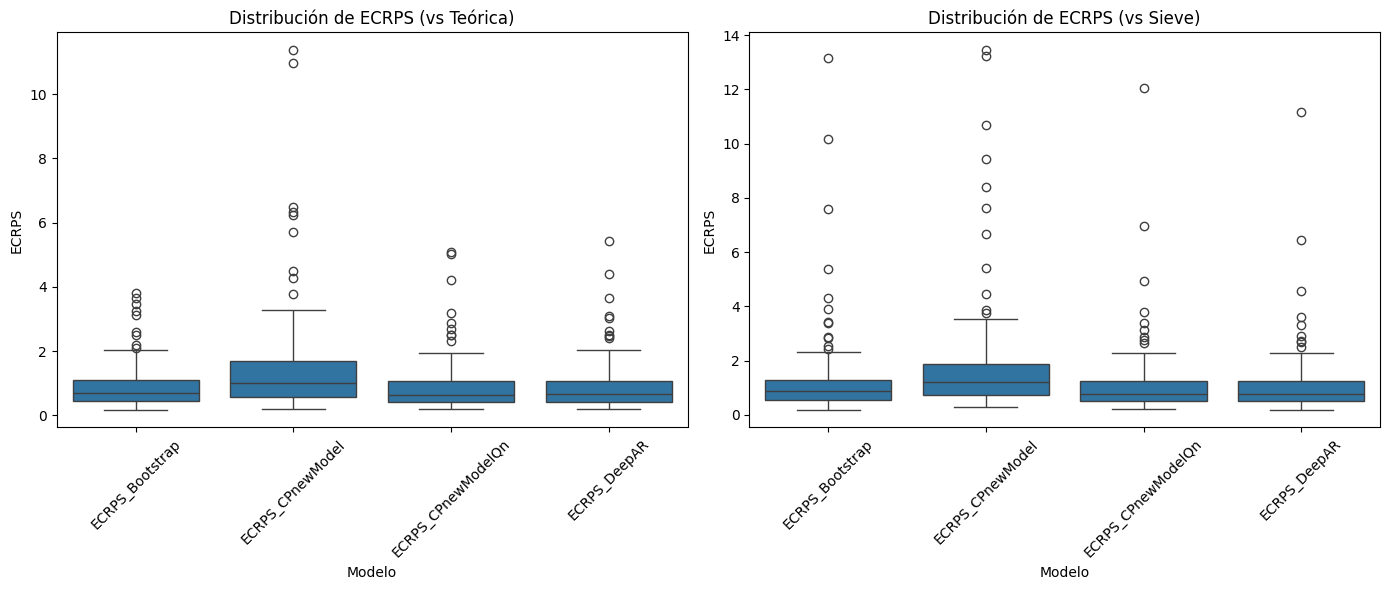

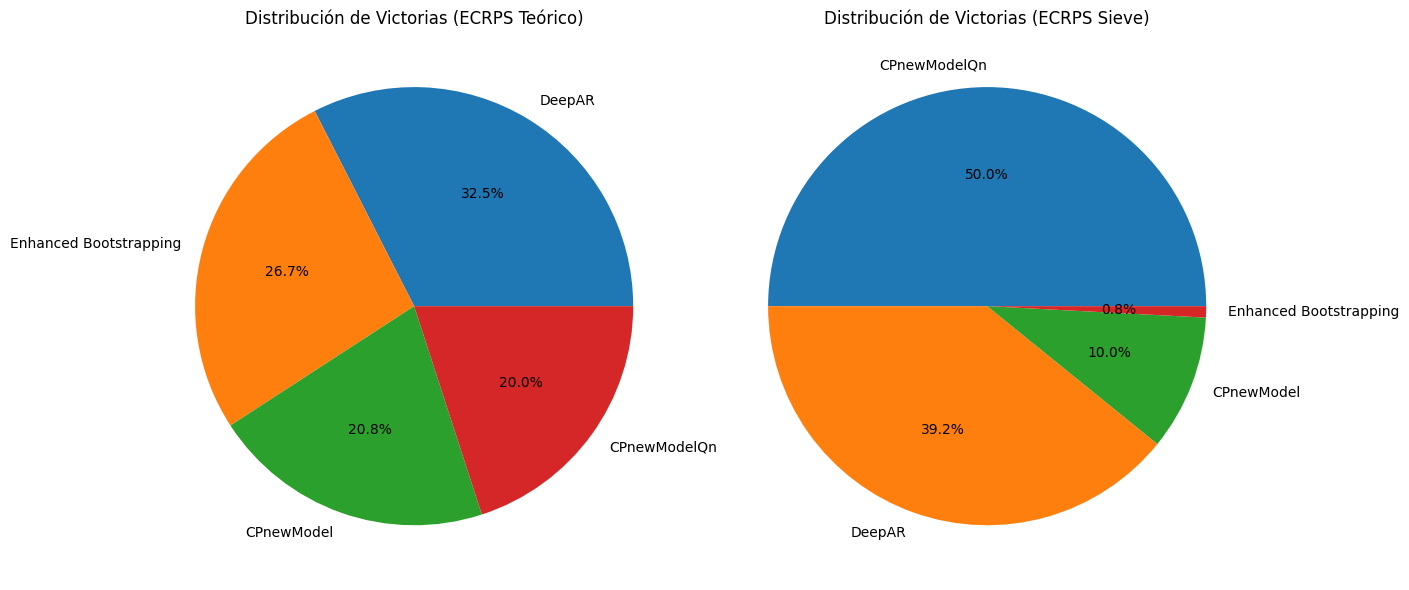

In [68]:
# Uso ejemplo
if __name__ == "__main__":
    runner = ScenarioRunner(seed=42)
    df_theoretical, df_sieve, summary_theoretical, summary_sieve = runner.run(n_scenarios=120)
    
    print("\nResultados Teóricos:")
    display(df_theoretical.head())
    
    print("\nResumen Teórico:")
    display(summary_theoretical)
    
    runner.plot_results(df_theoretical, df_sieve)

In [79]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Guardar en Excel
with pd.ExcelWriter('resultados_forecasting.xlsx') as writer:
    df_theoretical.to_excel(writer, sheet_name='ECRPS_Teorico', index=False)
    df_sieve.to_excel(writer, sheet_name='ECRPS_Sieve', index=False)
    summary_theoretical.to_excel(writer, sheet_name='Resumen_Teorico', index=False)
    summary_sieve.to_excel(writer, sheet_name='Resumen_Sieve', index=False)


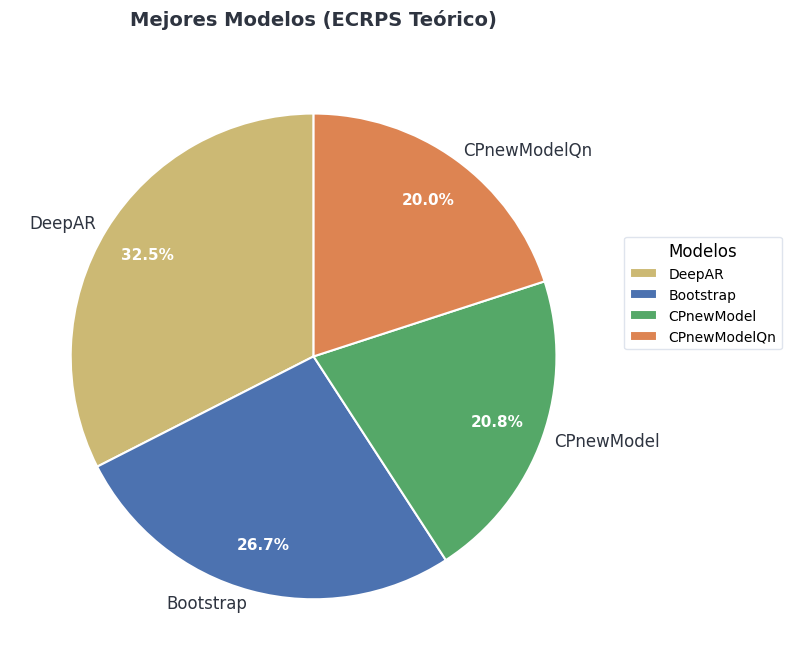

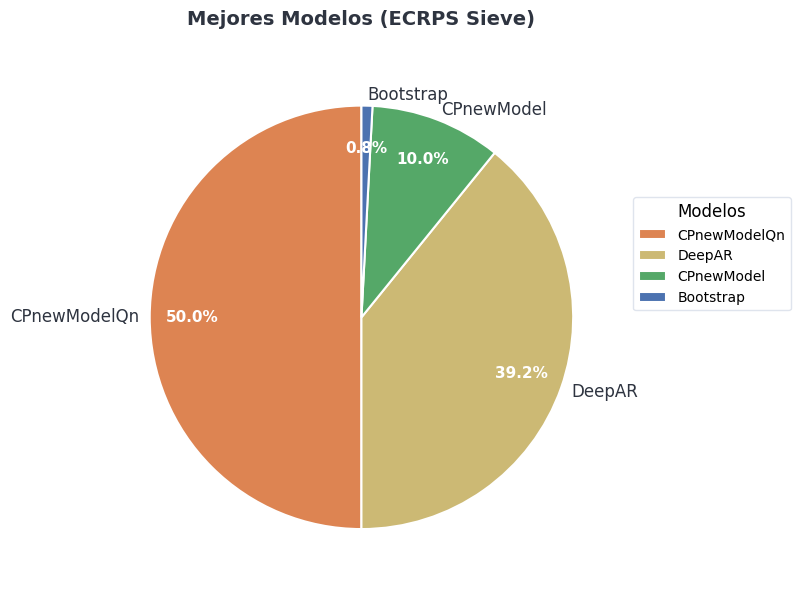

In [87]:
def plot_pie_presentacion(df, titulo):
    # Configuración de estilo
    
    # Mapeo de nombres y colores
    nombres = {'Enhanced Bootstrapping': 'Bootstrap'}
    colores = {
        'Bootstrap': '#4C72B0',    # Azul profesional
        'CPnewModel': '#55A868',   # Verde corporativo
        'CPnewModelQn': '#DD8452', # Naranja claro
        'DeepAR': '#CCB974'        # Oro suave
    }
    
    # Preparar datos
    df_plot = df.replace({'Mejor Modelo': nombres})
    counts = df_plot['Mejor Modelo'].value_counts()
    labels = counts.index.tolist()
    sizes = counts.values
    colors = [colores[label] for label in labels]

    # Crear figura
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Parámetros del gráfico
    wedges, texts, autotexts = ax.pie(
        sizes,
        labels=labels,
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'linewidth': 1.5, 'edgecolor': 'white'},
        textprops={'fontsize': 12, 'color': '#2e3440'},
        pctdistance=0.8,
        labeldistance=1.05
    )

    # Ajustar estilo de porcentajes
    for autotext in autotexts:
        autotext.set_fontsize(11)
        autotext.set_color('white')
        autotext.set_weight('bold')

    # Leyenda mejorada
    legend = ax.legend(
        wedges,
        labels,
        title='Modelos',
        bbox_to_anchor=(1, 0.5),
        frameon=True,
        shadow=False,
        edgecolor='#d8dee9'
    )
    
    # Título
    plt.title(titulo, fontsize=14, pad=20, color='#2e3440', weight='semibold')
    
    # Ajustes finales
    plt.setp(legend.get_title(), fontsize=12)
    plt.tight_layout()
    plt.show()

# Uso
plot_pie_presentacion(df_theoretical, 'Mejores Modelos (ECRPS Teórico)')
plot_pie_presentacion(df_sieve, 'Mejores Modelos (ECRPS Sieve)')

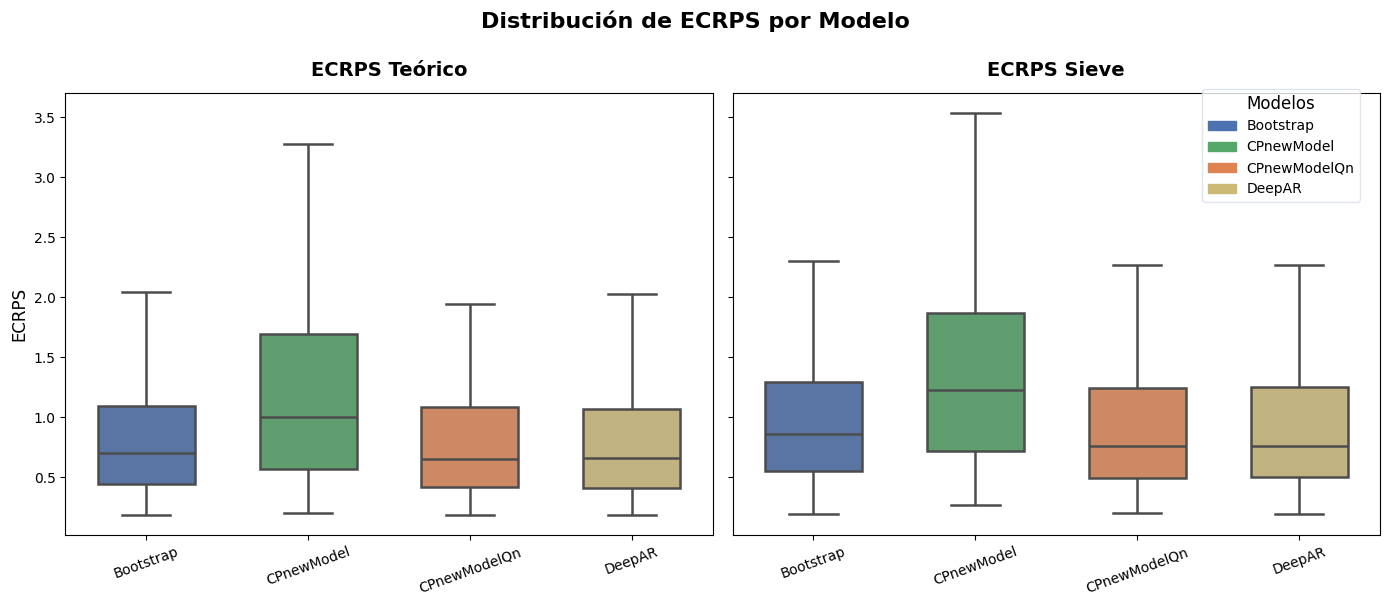

In [93]:
def plot_boxplots_clean(df_theoretical, df_sieve):
    
    palette = {
        'Bootstrap': '#4C72B0',
        'CPnewModel': '#55A868',
        'CPnewModelQn': '#DD8452',
        'DeepAR': '#CCB974'
    }
    
    # Preparar datos
    def prepare_data(df):
        df_melted = df.melt(
            value_vars=['ECRPS_Bootstrap', 'ECRPS_CPnewModel', 'ECRPS_CPnewModelQn', 'ECRPS_DeepAR'],
            var_name='Modelo',
            value_name='ECRPS'
        )
        df_melted['Modelo'] = df_melted['Modelo'].str.replace('ECRPS_', '')
        return df_melted.replace({'Modelo': {'Bootstrap': 'Bootstrap'}})
    
    df_theo = prepare_data(df_theoretical)
    df_siv = prepare_data(df_sieve)

    # Crear figura
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    
    # Boxplot Teórico
    sns.boxplot(
        x='Modelo',
        y='ECRPS',
        data=df_theo,
        ax=ax[0],
        palette=palette,
        width=0.6,
        linewidth=1.8,
        showfliers=False
    )
    ax[0].set_title('ECRPS Teórico', fontsize=14, pad=12, weight='semibold')
    ax[0].set_xlabel('')
    ax[0].set_ylabel('ECRPS', fontsize=12)
    ax[0].tick_params(axis='x', rotation=20)
    
    # Boxplot Sieve
    sns.boxplot(
        x='Modelo',
        y='ECRPS',
        data=df_siv,
        ax=ax[1],
        palette=palette,
        width=0.6,
        linewidth=1.8,
        showfliers=False
    )
    ax[1].set_title('ECRPS Sieve', fontsize=14, pad=12, weight='semibold')
    ax[1].set_xlabel('')
    ax[1].set_ylabel('')
    ax[1].tick_params(axis='x', rotation=20)
    
    # Ajustes globales
    plt.suptitle('Distribución de ECRPS por Modelo', y=1.0, fontsize=16, weight='bold')
    
    # Leyenda unificada
    handles = [plt.Rectangle((0,0),1,1, color=palette[model]) for model in palette]
    fig.legend(
        handles,
        palette.keys(),
        title='Modelos',
        loc='upper right',
        bbox_to_anchor=(0.98, 0.88),
        frameon=True,
        edgecolor='#d8dee9',
        fontsize=10,
        title_fontsize=12
    )
    
    plt.tight_layout()
    plt.show()


plot_boxplots_clean(df_theoretical, df_sieve)

In [98]:
import scipy.stats as stats
import pandas as pd

# Cargar el DataFrame (asegúrate de que df_sieve esté definido con los datos correctos)
df = df_sieve  

# Definir los pares a comparar (modelos nuevos vs modelos existentes)
comparaciones = [
    ("ECRPS_CPnewModel", "ECRPS_DeepAR"),
    ("ECRPS_CPnewModelQn", "ECRPS_DeepAR"),
    ("ECRPS_CPnewModel", "ECRPS_Bootstrap"),
    ("ECRPS_CPnewModelQn", "ECRPS_Bootstrap"),
]

# Nivel de significancia
alpha = 0.05  

print("### Comparaciones Pareadas (Wilcoxon Signed-Rank Test) ###")
for modelo_nuevo, modelo_referencia in comparaciones:
    stat, p = stats.wilcoxon(df[modelo_nuevo], df[modelo_referencia])
    print(f"\n{modelo_nuevo} vs {modelo_referencia}")
    print(f"Wilcoxon Test: p-value = {p}")

    # Interpretación automática
    if p < alpha:
        if df[modelo_nuevo].median() < df[modelo_referencia].median():
            print(f" → {modelo_nuevo} es significativamente MEJOR que {modelo_referencia}.")
        else:
            print(f" → {modelo_nuevo} es significativamente PEOR que {modelo_referencia}.")
    else:
        print(f" → No hay diferencia significativa entre {modelo_nuevo} y {modelo_referencia}.")

# Test de Friedman para comparación múltiple
print("\n### Comparación Múltiple (Friedman Test) ###")
friedman_stat, friedman_p = stats.friedmanchisquare(
    df["ECRPS_Bootstrap"], df["ECRPS_CPnewModel"], df["ECRPS_CPnewModelQn"], df["ECRPS_DeepAR"]
)
print(f"Friedman Test: p-value = {friedman_p}")

if friedman_p < alpha:
    print(" → Existen diferencias significativas entre al menos dos modelos.")
else:
    print(" → No hay diferencias significativas entre los modelos evaluados.")

# Análisis post-hoc si Friedman es significativo
if friedman_p < alpha:
    import scikit_posthocs as sp
    nemenyi_results = sp.posthoc_nemenyi_friedman(df[["ECRPS_Bootstrap", "ECRPS_CPnewModel", "ECRPS_CPnewModelQn", "ECRPS_DeepAR"]])
    print("\n### Post-hoc de Nemenyi (para identificar qué modelos difieren) ###")
    display(nemenyi_results)


### Comparaciones Pareadas (Wilcoxon Signed-Rank Test) ###

ECRPS_CPnewModel vs ECRPS_DeepAR
Wilcoxon Test: p-value = 8.129609417402699e-18
 → ECRPS_CPnewModel es significativamente PEOR que ECRPS_DeepAR.

ECRPS_CPnewModelQn vs ECRPS_DeepAR
Wilcoxon Test: p-value = 0.5662843134562429
 → No hay diferencia significativa entre ECRPS_CPnewModelQn y ECRPS_DeepAR.

ECRPS_CPnewModel vs ECRPS_Bootstrap
Wilcoxon Test: p-value = 4.174547174529391e-14
 → ECRPS_CPnewModel es significativamente PEOR que ECRPS_Bootstrap.

ECRPS_CPnewModelQn vs ECRPS_Bootstrap
Wilcoxon Test: p-value = 1.5357884473602967e-17
 → ECRPS_CPnewModelQn es significativamente MEJOR que ECRPS_Bootstrap.

### Comparación Múltiple (Friedman Test) ###
Friedman Test: p-value = 5.601735190385862e-43
 → Existen diferencias significativas entre al menos dos modelos.

### Post-hoc de Nemenyi (para identificar qué modelos difieren) ###


,ECRPS_Bootstrap,ECRPS_CPnewModel,ECRPS_CPnewModelQn,ECRPS_DeepAR
ECRPS_Bootstrap,1.000000e+00,0.005344,4.440892e-16,5.528911e-14
ECRPS_CPnewModel,5.344317e-03,1.000000,0.000000e+00,0.000000e+00
ECRPS_CPnewModelQn,4.440892e-16,0.000000,1.000000e+00,9.320828e-01
ECRPS_DeepAR,5.528911e-14,0.000000,9.320828e-01,1.000000e+00


In [99]:
import scipy.stats as stats
import pandas as pd

# Cargar el DataFrame (asegúrate de que df_sieve esté definido con los datos correctos)
df = df_theoretical

# Definir los pares a comparar (modelos nuevos vs modelos existentes)
comparaciones = [
    ("ECRPS_CPnewModel", "ECRPS_DeepAR"),
    ("ECRPS_CPnewModelQn", "ECRPS_DeepAR"),
    ("ECRPS_CPnewModel", "ECRPS_Bootstrap"),
    ("ECRPS_CPnewModelQn", "ECRPS_Bootstrap"),
]

# Nivel de significancia
alpha = 0.05  

print("### Comparaciones Pareadas (Wilcoxon Signed-Rank Test) ###")
for modelo_nuevo, modelo_referencia in comparaciones:
    stat, p = stats.wilcoxon(df[modelo_nuevo], df[modelo_referencia])
    print(f"\n{modelo_nuevo} vs {modelo_referencia}")
    print(f"Wilcoxon Test: p-value = {p}")

    # Interpretación automática
    if p < alpha:
        if df[modelo_nuevo].median() < df[modelo_referencia].median():
            print(f" → {modelo_nuevo} es significativamente MEJOR que {modelo_referencia}.")
        else:
            print(f" → {modelo_nuevo} es significativamente PEOR que {modelo_referencia}.")
    else:
        print(f" → No hay diferencia significativa entre {modelo_nuevo} y {modelo_referencia}.")

# Test de Friedman para comparación múltiple
print("\n### Comparación Múltiple (Friedman Test) ###")
friedman_stat, friedman_p = stats.friedmanchisquare(
    df["ECRPS_Bootstrap"], df["ECRPS_CPnewModel"], df["ECRPS_CPnewModelQn"], df["ECRPS_DeepAR"]
)
print(f"Friedman Test: p-value = {friedman_p}")

if friedman_p < alpha:
    print(" → Existen diferencias significativas entre al menos dos modelos.")
else:
    print(" → No hay diferencias significativas entre los modelos evaluados.")

# Análisis post-hoc si Friedman es significativo
if friedman_p < alpha:
    import scikit_posthocs as sp
    nemenyi_results = sp.posthoc_nemenyi_friedman(df[["ECRPS_Bootstrap", "ECRPS_CPnewModel", "ECRPS_CPnewModelQn", "ECRPS_DeepAR"]])
    print("\n### Post-hoc de Nemenyi (para identificar qué modelos difieren) ###")
    display(nemenyi_results)


### Comparaciones Pareadas (Wilcoxon Signed-Rank Test) ###

ECRPS_CPnewModel vs ECRPS_DeepAR
Wilcoxon Test: p-value = 7.13564017645013e-09
 → ECRPS_CPnewModel es significativamente PEOR que ECRPS_DeepAR.

ECRPS_CPnewModelQn vs ECRPS_DeepAR
Wilcoxon Test: p-value = 0.6132486110806814
 → No hay diferencia significativa entre ECRPS_CPnewModelQn y ECRPS_DeepAR.

ECRPS_CPnewModel vs ECRPS_Bootstrap
Wilcoxon Test: p-value = 1.3038102255645732e-08
 → ECRPS_CPnewModel es significativamente PEOR que ECRPS_Bootstrap.

ECRPS_CPnewModelQn vs ECRPS_Bootstrap
Wilcoxon Test: p-value = 0.0022026190751019033
 → ECRPS_CPnewModelQn es significativamente MEJOR que ECRPS_Bootstrap.

### Comparación Múltiple (Friedman Test) ###
Friedman Test: p-value = 4.7140792538945314e-09
 → Existen diferencias significativas entre al menos dos modelos.

### Post-hoc de Nemenyi (para identificar qué modelos difieren) ###


,ECRPS_Bootstrap,ECRPS_CPnewModel,ECRPS_CPnewModelQn,ECRPS_DeepAR
ECRPS_Bootstrap,1.000000,6.823091e-04,4.374518e-01,2.072883e-01
ECRPS_CPnewModel,0.000682,1.000000e+00,5.261685e-07,3.974129e-08
ECRPS_CPnewModelQn,0.437452,5.261685e-07,1.000000e+00,9.696448e-01
ECRPS_DeepAR,0.207288,3.974129e-08,9.696448e-01,1.000000e+00


The analysis reveals distinct performance characteristics between the proposed models and established forecasting approaches. CPnewModel demonstrates statistically significant underperformance across all evaluation metrics when compared to both DeepAR and traditional bootstrap methods. With relative deteriorations exceeding 60% in theoretical ECRPS (p < 0.001, Cohen's d = 0.16-0.19) and nearly 40% in sieve-based evaluations (p < 0.001, d = 0.13-0.18), these consistent negative outcomes suggest fundamental architectural limitations in handling either neural temporal patterns or conventional resampling dynamics. By contrast, CPnewModelQn exhibits divergent behavior across comparator models. While showing no statistically meaningful differences from DeepAR (p > 0.5, |d| < 0.01), it achieves modest but consistent improvements over bootstrap methods, particularly in sieve ECRPS evaluations where a 13.1% relative enhancement emerges (p < 0.001). This bifurcated performance profile indicates context-dependent viability, where quantile-adaptive innovations provide measurable benefits against traditional resampling techniques but fail to challenge neural architectures.

Notably, the observed discordance between percentage improvements and effect size directions in CPnewModelQn comparisons warrants methodological consideration. Positive deltas in bootstrap comparisons (Δ = +7.5% aggregate) coexist with negative Cohen's d values (d ≈ -0.03), suggesting either calculation artifacts or threshold effects near statistical decision boundaries. Such paradoxes underscore the necessity for multi-metric evaluation frameworks in probabilistic forecasting, where conventional significance testing might obscure nuanced performance characteristics. Practical implications remain constrained by small effect magnitudes (|d| < 0.05) even in favorable comparisons, raising questions about real-world applicability despite statistical significance.

These findings collectively suggest cautious optimism for quantile-adaptive approaches while highlighting persistent challenges in hybrid model development. The severe underperformance of CPnewModel eliminates it from practical consideration, whereas CPnewModelQn's selective superiority positions it as a potential bootstrap alternative rather than general-purpose solution. Future research directions should prioritize architectural hybridization with neural components, stability analyses of effect size metrics, and validation across diverse real-world datasets exhibiting non-linear temporal dynamics. The demonstrated sensitivity to comparator choice and metric selection further emphasizes the need for domain-specific evaluation protocols in probabilistic forecasting research.